In [1]:
import matplotlib.pyplot as plt
# Set global font size parameters
plt.rcParams.update({
    'font.size': 18,              # Base font size
    'axes.titlesize': 20,         # Title font size
    'axes.labelsize': 16,         # Label font size
    #'axes.labelweight': 'bold',   # Make axis labels bold
    'xtick.labelsize': 14,        # X-tick label size
    'ytick.labelsize': 14,        # Y-tick label size
    'legend.fontsize': 14,        # Legend font size
    'figure.titlesize': 20,        # Figure title size
    'text.usetex': True,          # Use LaTeX for all text rendering
    'text.latex.preamble': r'\usepackage{amsmath}'  # Use AMS math for LaTeX
})

In [2]:
import sys
import os
from pathlib import Path
import numpy as np

# Get the directory of the current script
script_dir = Path(os.getcwd()).resolve()

# Add the src directory to the Python path
sys.path.append(str(Path(script_dir / '../src').resolve()))

figure_dir = '../data/processed/plots/manual/'
if not os.path.exists(figure_dir):
    os.makedirs(figure_dir)

import numpy as np
from utils import convert_units
from model import model

units = np.random.choice(list(convert_units.keys())) # This chooses a random energy scale among [MeV, GeV, TeV]

# This selects a pair of couplings for which we expect a first-order phase transition over large intervals of vevs
lambda_ = 1.65e-3
g = 0.54
#vev = np.random.uniform(0, 1e3) # This chooses a random vev between [0, 1e3] in the selected units
vev, units = 500, "MeV"
description = "Fast"

# Alternatively, these are the bechmark points presented in arXiv:2501.15649 [hep-ph]
lambda_, g, vev, units, description  = 6e-3, 0.75002, 500, "MeV", "Slow" # BP1
# lambda_, g, vev, units, description  = 6e-3, 0.74982, 1000, "MeV", "BP2"
# lambda_, g, vev, units, description  = 6e-3, 0.74972, 3, "GeV", "BP3" 
# lambda_, g, vev, units, description  = 1e-2, 0.85412, 1, "GeV", "BP4"

#lambda_, g, vev, units, description =  4.488898148959398e-03, 6.972679726505687e-01, 4.410345365114855e+01, "MeV", "MCMC_MAP"
#lambda_, g, vev, units, description =  3.2068687910412159e-03, 6.4097070950050705e-01, 1.1413675256191728e+02, "MeV", "Bayes"
#lambda_, g, vev, units, description =  1.5052724071742338e-03, 5.3053740660784832e-01, 4.6720288890003964e+01, "MeV", "MCMC_MLE"

# This constructs the finite-temperature potential as an instance of the class model. 
dp = model(vev, lambda_, g, xstep= vev * 1e-3, Tstep=vev * 1e-3)
V = dp.DVtot # This is the scalar potential shifted such that the false vacuum is located at ϕ = 0 for each value of the temperature
dV = dp.gradV # This is the gradient of the scalar potential

print(f"lambda = {lambda_}")
print(f"g = {g}")
print(f"vev = {vev} {units}")

lambda = 0.006
g = 0.75002
vev = 500 MeV


In [3]:
from cosmoTransitions import transitionFinder
from cosmoTransitions.transitionFinder import getStartPhase

import time
start_time = time.time()
for _ in range(10):
    phases = dp.getPhases()
end_time = time.time()
CT_time = (end_time - start_time) / 10

start_phase = phases[getStartPhase(phases, V)]

if len(phases) > 1:
    Tall = transitionFinder.findCriticalTemperatures(phases, V)
    Tcrit = Tall[0]['Tcrit']
    T_min_CT = start_phase.T[0]
    T_max_CT = Tcrit

    print(f"T_max = {T_max_CT:.6e} {units}")
    print(f"T_min = {T_min_CT:.6e} {units}")

print("\nFound", len(phases), "phases")

print("\nElapsed time:", end_time - start_time, "s")

Tracing phase starting at x = [499.99993156] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
............................
Tracing phase starting at x = [0.] ; t = 138.69774436950684
Tracing minimum down
traceMinimum t0 = 138.698
...............
Tracing minimum up
traceMinimum t0 = 138.698
..........
Tracing phase starting at x = [499.99993156] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
............................
Tracing phase starting at x = [0.] ; t = 138.69774436950684
Tracing minimum down
traceMinimum t0 = 138.698
...............
Tracing minimum up
traceMinimum t0 = 138.698
..........
Tracing phase starting at x = [499.99993156] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0
............................
Tracing phase starting at x = [0.] ; t = 138.69774436950684
Tracing minimum down
traceMinimum t0 = 138.698
...............
Tracing minimum up
traceMinimum t0 = 138.698
..........
Tracing phase starting at x = [499.99993156] ; t = 0.0
Tracing minimum up
traceMinimum t0 = 0


In [4]:
from temperatures import find_T_min, find_T_max, refine_Tmin

start_time = time.time()

for _ in range(10):
    T_max, vevs_max, max_min_vals, false_min_tmax = find_T_max(V, dV, precision= 1e-2, Phimax = 2*vev, step_phi = vev * 1e-2, tmax=2.5 * vev)
    T_min, vevs_min, false_min_tmin = find_T_min(V, dV, tmax=T_max, precision = 1e-2, Phimax = 2*vev, step_phi = vev * 1e-2, max_min_vals = max_min_vals)

    if T_max is not None and T_min is not None:
        maxvev = np.max(np.concatenate((vevs_max, vevs_min)))
    elif T_max is not None:
        maxvev = np.max(vevs_max)
    elif T_min is not None:
        maxvev = np.max(vevs_min)
    else:
        maxvev = None

    T_min = refine_Tmin(T_min, V, dV, maxvev, log_10_precision = 6) if T_min is not None else None

end_time = time.time()

ELENA_time = (end_time - start_time) / 10

print("\nElapsed time:", end_time - start_time, "s")

print(f"T_max = {T_max:.6e} {units}")
print(f"T_min = {T_min:.6e} {units}")


Elapsed time: 1.1627962589263916 s
T_max = 1.157500e+02 MeV
T_min = 0.000000e+00 MeV


In [5]:
print(f"ELENA, {description}, {T_max:.2f}, {T_min:.2f}, {ELENA_time:.2f}")
print(f"CT, {description}, {T_max_CT:.2f}, {T_min_CT:.2f}, {CT_time:.2f}", len(phases))

ELENA, Slow, 115.75, 0.00, 0.12
CT, Slow, 115.78, 0.00, 0.14 2


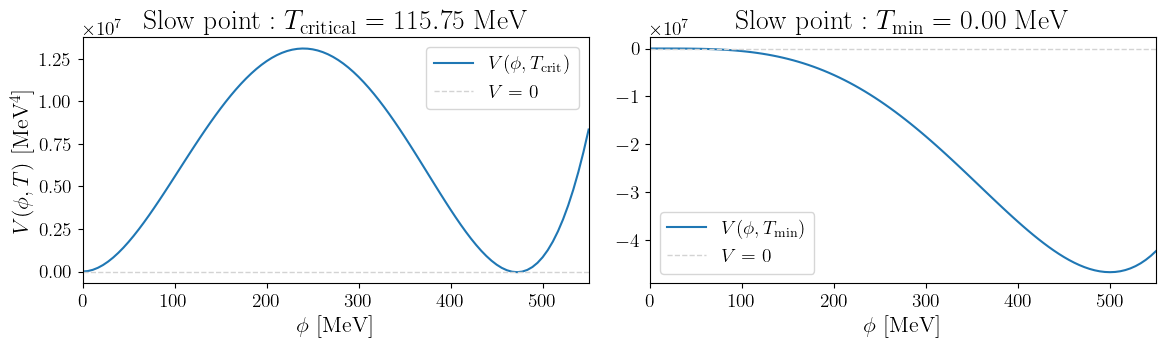

In [6]:
phi = np.linspace(0, 1.1 * vev, 100)
phi = phi.reshape(-1,1)

if T_max is not None: v_max = V(phi, T_max)
if T_min is not None: v_min = V(phi, T_min)

fig, axes = plt.subplots(1, 2, figsize=(12, 4))

if T_max is not None: 
    v_max = V(phi, T_max)
    axes[0].plot(phi, v_max, label = '$V(\phi, T_\\mathrm{{crit}})$')
    axes[0].set_title(f'$\mathrm{{{description}\ point:}}\ T_{{\\mathrm{{critical}}}} = {T_max:.2f}\ \mathrm{{{units}}}$')
    axes[0].set_xlim(phi[0], phi[-1])
    axes[0].set_ylabel(f"$V(\phi, T)$ $\mathrm{{[{units}^4]}}$")

if T_min is not None: 
    v_min = V(phi, T_min)
    axes[1].plot(phi, v_min, label= '$V(\phi, T_\\mathrm{{min}})$')
    axes[1].set_title(f'$\mathrm{{{description}\ point:}}\ T_{{\\mathrm{{min}}}} = {T_min:.2f}\ \mathrm{{{units}}}$')
    axes[1].set_xlim(phi[0], phi[-1])

for ax in axes:
    ax.set_xlabel(f"$\phi\ \mathrm{{[{units}]}}$")
    ax.axhline(false_min_tmax[1], color='lightgrey', linestyle='--', linewidth=1, label = "$V = 0$")
    ax.legend()

plt.tight_layout()
plt.savefig(figure_dir + f"potential_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [7]:
from scipy import optimize
from cosmoTransitions.pathDeformation import fullTunneling

phitol = 1e-8

def act(T):
    def V_(x,T=T,V=V): return V(x,T)
    def dV_(x,T=T,dV=dV): return dV(x,T)

    def fmin(x):
        return optimize.fmin(V, x, args=(T,), xtol=phitol, ftol=np.inf, disp=False)

    high_vev = fmin(start_phase.valAt(T))
    low_vev = fmin(phases[0].valAt(T))

    tunn = fullTunneling([low_vev, high_vev], V_, dV_)
    action_over_T = tunn.action / T
    return action_over_T

In [8]:
from espinosa import Vt_vec

true_vev = {}
S3overT = {}
V_min_value = {}
phi0_min = {}
V_exit = {}
false_vev = {}

def action_over_T(T, c_step_phi = 1e-3, precision = 1e-3):
    instance = Vt_vec(T, V, dV, step_phi = c_step_phi, precision = precision, vev0 = maxvev)
    if instance.barrier:
        true_vev[T] = instance.true_min
        false_vev[T] = instance.phi_original_false_vev
        S3overT[T] = instance.action_over_T
        V_min_value[T] = instance.min_V
        phi0_min[T] = instance.phi0_min
        V_exit[T] = instance.V_exit
        return instance.action_over_T
    else:
        return None

Define a function that fits the potential at given T to the form $V = m \phi^2 + \eta \phi^3 + \lambda \phi^4$ and computes the action following eq. (13) in 2404.17632

In [9]:
from numpy.linalg import lstsq

def S(D, e):
    return (1 / e**(D - 1) * ((D - 1) / 3)**(D - 1) * 2 / (3 * D)) * (1 + 8.5 * e + (8.21 + 1.35 * np.sqrt(1 - e)) * e**2 - 2.51 * e**3)

def quartic_coeff(T, phimin = 0, phimax = 100, steps = 100):
    dphi = (phimax - phimin) / steps
    # Generate the data
    phi = np.arange(phimin, phimax + dphi, dphi)
    temp2 = phi.reshape(-1,1)

    Vnum = V(temp2, T)

    # Construct the design matrix for the terms phi^2, phi^3, and phi^4
    A = np.vstack([phi**2, phi**3, phi**4]).T

    # Solve the least squares problem to find the coefficients
    coefficients, _, _, _ = lstsq(A, Vnum, rcond=None)

    return coefficients
    

def action_conf(T, phimin = 0, phimax = 100, steps = 100):
    coefficients = quartic_coeff(T, phimin, phimax, steps)

    m, n, l = coefficients

    m2 = 2*m
    lam = 8*l
    eps = 1 - (lam*m2)/(4*n**2)
    discr = 9 * n**2 - 32*l*m

    action3d = 4*np.pi * np.sqrt(m2) * (1-eps)*S(3, eps) / (lam) if 0 <= eps <= 1 else None

    return action3d, coefficients

In [10]:
if len(phases) > 1:
    x = np.linspace(max(T_min, T_min_CT), min(T_max , T_max_CT), 100)
else:
    x = np.linspace(T_min, T_max, 100)
    
vec = np.vectorize(act)

# Filter the valid points
valid_x = []
valid_y = []
start = time.time()
#print("CosmoTransitions")
for xi in x:
    try:
        yi = act(xi)
        valid_x.append(xi)
        valid_y.append(yi)
    except Exception as e:
        # Ignore the points that cause an error
        pass
end = time.time()
CT_time = end - start
print(f"CosmoTransitions took {CT_time:.2f} seconds")
valid_x = np.array(valid_x)
valid_y = np.array(valid_y)

vec = np.vectorize(action_over_T)
start = time.time()
y = vec(x)
end = time.time()
ELENA_time = end - start

print(f"ELENA took {ELENA_time:.2f} seconds")


# Filter the valid points
valid_x_CF = []
valid_y_CF = []
start = time.time()
#print("CosmoTransitions")
for xi in x:
    try:
        yi = action_conf(xi, 0, vev)[0]/xi
        valid_x_CF.append(xi)
        valid_y_CF.append(yi)
    except Exception as e:
        # Ignore the points that cause an error
        pass
end = time.time()
CF_time = end - start
print(f"Conformal approx took {CF_time:.2f} seconds")
valid_x_CF = np.array(valid_x_CF)
valid_y_CF = np.array(valid_y_CF)


NaN result encountered.
Path deformation converged. 1 steps. fRatio = 2.55796e-13
Path deformation converged. 1 steps. fRatio = 7.55918e-14
Path deformation converged. 1 steps. fRatio = 6.49268e-14
Path deformation converged. 1 steps. fRatio = 5.96851e-14


/Users/michele/miniconda3/envs/nanograv/lib/python3.10/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in scalar multiply
  beta_r = beta*r
/Users/michele/miniconda3/envs/nanograv/lib/python3.10/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in scalar multiply
  beta_r = beta*r
/Users/michele/miniconda3/envs/nanograv/lib/python3.10/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in scalar multiply
  r *= 10
/Users/michele/miniconda3/envs/nanograv/lib/python3.10/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in scalar multiply
  beta_r = beta*r


Path deformation converged. 1 steps. fRatio = 7.27942e-14
Path deformation converged. 1 steps. fRatio = 3.32738e-14
Path deformation converged. 1 steps. fRatio = 6.08408e-14
Path deformation converged. 1 steps. fRatio = 5.57165e-14
Path deformation converged. 1 steps. fRatio = 7.68269e-14
Path deformation converged. 1 steps. fRatio = 4.72738e-14
Path deformation converged. 1 steps. fRatio = 6.56783e-14
Path deformation converged. 1 steps. fRatio = 4.07155e-14
Path deformation converged. 1 steps. fRatio = 5.69711e-14
Path deformation converged. 1 steps. fRatio = 3.55651e-14
Path deformation converged. 1 steps. fRatio = 6.68058e-14
Path deformation converged. 1 steps. fRatio = 3.14682e-14
Path deformation converged. 1 steps. fRatio = 5.93593e-14
Path deformation converged. 1 steps. fRatio = 5.61646e-14
Path deformation converged. 1 steps. fRatio = 7.99147e-14
Path deformation converged. 1 steps. fRatio = 7.59430e-14
Path deformation converged. 1 steps. fRatio = 7.23180e-14
Path deformati

/Users/michele/miniconda3/envs/nanograv/lib/python3.10/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in scalar multiply
  beta_r = beta*r
/Users/michele/miniconda3/envs/nanograv/lib/python3.10/site-packages/cosmoTransitions/tunneling1D.py:415: RuntimeWarning: overflow encountered in scalar multiply
  r *= 10
/Users/michele/miniconda3/envs/nanograv/lib/python3.10/site-packages/cosmoTransitions/tunneling1D.py:331: RuntimeWarning: overflow encountered in scalar multiply
  beta_r = beta*r


Path deformation converged. 1 steps. fRatio = 9.03023e-14
CosmoTransitions took 4.53 seconds
ELENA took 1.68 seconds
Conformal approx took 0.04 seconds


/var/folders/04/fp1djbdn4s5976r1jm7nkrsw0000gn/T/ipykernel_15838/270892173.py:43: RuntimeWarning: divide by zero encountered in scalar divide
  yi = action_conf(xi, 0, vev)[0]/xi


In [22]:
for i in range(len(valid_y)):
    print(f"{valid_x[i]:.6e}, {valid_y[i]:.6e}, {y[i]:.6e}")

2.338384e+00, -1.391945e+11, inf
3.507576e+00, 6.748211e+01, 7.873299e+02
4.676768e+00, 2.259477e+02, 4.024720e+02
5.845960e+00, 2.006989e+02, 2.823389e+02
7.015152e+00, 1.859331e+02, 2.294605e+02
8.184343e+00, 1.774567e+02, 2.022794e+02
9.353535e+00, 1.730613e+02, 1.877797e+02
1.052273e+01, 1.712288e+02, 1.801026e+02
1.169192e+01, 1.707154e+02, 1.759323e+02
1.286111e+01, 1.715774e+02, 1.747096e+02
1.403030e+01, 1.732971e+02, 1.746959e+02
1.519949e+01, 1.755197e+02, 1.758024e+02
1.636869e+01, 1.782972e+02, 1.777108e+02
1.753788e+01, 1.812977e+02, 1.802149e+02
1.870707e+01, 1.846053e+02, 1.831634e+02
1.987626e+01, 1.881400e+02, 1.864654e+02
2.104545e+01, 1.924237e+02, 1.900507e+02
2.221465e+01, 1.966198e+02, 1.938896e+02
2.338384e+01, 2.008025e+02, 1.979109e+02
2.455303e+01, 2.053660e+02, 2.024238e+02
2.572222e+01, 2.100777e+02, 2.070902e+02
2.689141e+01, 2.148988e+02, 2.116277e+02
2.806061e+01, 2.198575e+02, 2.165803e+02
2.922980e+01, 2.249666e+02, 2.214014e+02
3.039899e+01, 2.301807e+

In [11]:
n_points = 100
temperatures = np.linspace(T_min, T_max, n_points)
action_vec = np.vectorize(action_over_T)

temperatures = np.array([T for T in temperatures if T in S3overT])

from utils import interpolation_narrow
from temperatures import compute_logP_f, N_bubblesH, R_sepH

is_physical = True

def is_increasing(arr):
    return np.all(arr[:-1] <= arr[1:])

counter = 0
while counter <= 1:
    if counter == 1:
        temperatures = np.linspace(np.nanmax([T_min, 0.95 * T_completion]), np.nanmin([T_max, 1.05 * T_nuc]), n_points, endpoint = True)
        action_vec(temperatures)
    logP_f, Temps, ratio_V, Gamma, H = compute_logP_f(dp, V_min_value, S3overT, v_w = 1, units = units, cum_method= 'None')
    RH, R = R_sepH(Temps, Gamma, logP_f, H, ratio_V)
    nH = N_bubblesH(Temps, Gamma, logP_f, H, ratio_V)
    mask_nH = ~np.isnan(nH)
    T_nuc = interpolation_narrow(np.log(nH[mask_nH]), Temps[mask_nH], 0)
    mask_Pf = ~np.isnan(logP_f)
    T_perc = interpolation_narrow(logP_f[mask_Pf], Temps[mask_Pf], np.log(0.71))
    T_completion = interpolation_narrow(logP_f[mask_Pf], Temps[mask_Pf], np.log(0.01))
    idx_compl = np.max([np.argmin(np.abs(Temps - T_completion)), 1])
    test_completion = np.array([logP_f[idx_compl - 1], logP_f[idx_compl], logP_f[idx_compl + 1]])
    test_completion = test_completion[~np.isnan(test_completion)]
    print(counter, T_completion, test_completion)
    print(is_increasing(test_completion))
    if not is_increasing(test_completion):
        T_completion = np.nan
    if counter == 1:
        d_dT_logP_f = np.gradient(logP_f, Temps)
        log_at_T_perc = interpolation_narrow(Temps, d_dT_logP_f, T_perc)
        ratio_V_at_T_perc = interpolation_narrow(Temps, ratio_V, T_perc)
        log_at_T_completion = interpolation_narrow(Temps, d_dT_logP_f, T_completion)
        ratio_V_at_T_completion = interpolation_narrow(Temps, ratio_V, T_completion)
        if ratio_V_at_T_perc > log_at_T_perc:
            is_physical = False
            print("\n *** The physical volume at percolation is not decreasing. The production of GW is questionable ***")
    counter += 1

milestones = [T_max, T_nuc, T_perc, T_completion, T_min]
milestones = [milestone for milestone in milestones if milestone is not None and not np.isnan(milestone)]
action_vec(milestones)

# This is just for plotting purposes
t_mil_min, t_mil_max = np.nanmin([T_completion, T_perc, T_nuc]), np.nanmax([T_completion, T_perc, T_nuc])
idx_min = max(np.argmin(np.abs(Temps - t_mil_min)), 0)
idx_max = min(np.argmin(np.abs(Temps - t_mil_max)), len(Temps) - 1)
idx_min = idx_min if Temps[idx_min] <= t_mil_min else idx_min - 1
idx_max = idx_max if Temps[idx_max] >= t_mil_max else idx_max + 1
mask = (Temps >= Temps[idx_min]) & (Temps <= Temps[idx_max])

print(f"\nT_nuc = {T_nuc:.6e} {units}")
print(f"T_perc = {T_perc:.6e} {units}")
print(f"T_completion = {T_completion:.6e} {units}\n")

0 6.538718424901325 [-6.48348581 -3.31339059 -1.435168  ]
True


/Users/michele/scratch/ELENA_release/src/temperatures.py:360: RuntimeWarning: invalid value encountered in multiply
  Gamma_list = Temps**4 * (S3_T / (2 * np.pi))**(3/2) * np.exp(-S3_T)
/Users/michele/scratch/ELENA_release/src/temperatures.py:374: RuntimeWarning: overflow encountered in exp
  f1 = ratio_V[i:] / H[i:] * np.exp(cum_ratio_V / 3.)
/Users/michele/scratch/ELENA_release/src/temperatures.py:377: RuntimeWarning: invalid value encountered in multiply
  f2 = f_ext[i:] * np.exp(- cum_ratio_V) * cum_f1**3
/Users/michele/scratch/ELENA_release/src/temperatures.py:407: RuntimeWarning: divide by zero encountered in power
  return n**(-1/3) * H, n**(-1/3)
/var/folders/04/fp1djbdn4s5976r1jm7nkrsw0000gn/T/ipykernel_15838/3641130818.py:24: RuntimeWarning: divide by zero encountered in log
  T_nuc = interpolation_narrow(np.log(nH[mask_nH]), Temps[mask_nH], 0)


1 6.385949081721302 [-4.83924522 -4.60549281 -4.37974565]
True

T_nuc = 1.393805e+01 MeV
T_perc = 9.607274e+00 MeV
T_completion = 6.385949e+00 MeV



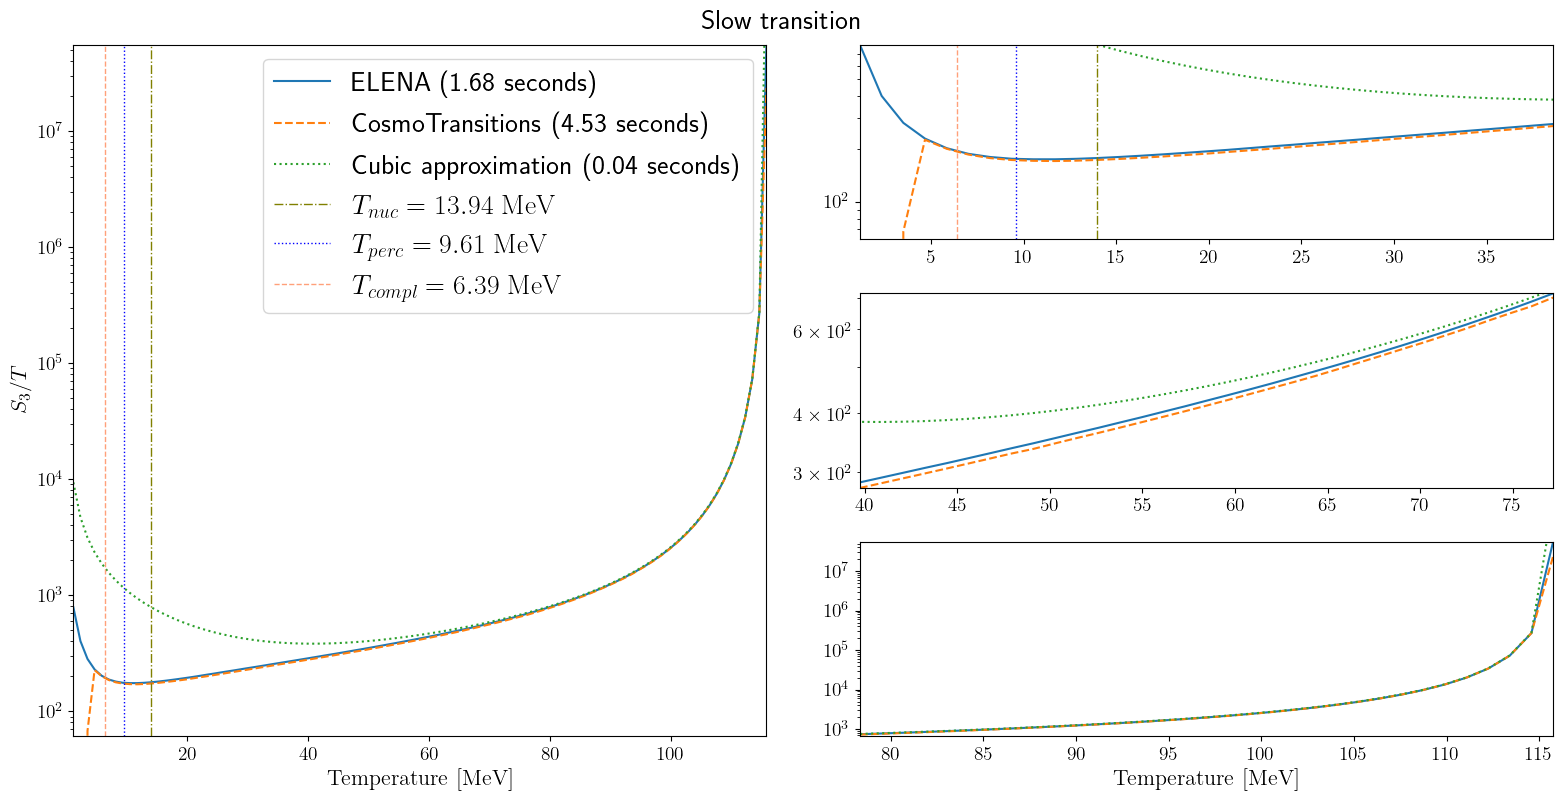

In [12]:
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(16, 8))

# Main plot (left side, full height)
ax_main = plt.subplot2grid((3, 2), (0, 0), rowspan=3)
ax_main.plot(x, y, label=f'ELENA ({ELENA_time:.2f} seconds)')
if len(phases) > 1:
    ax_main.plot(valid_x, valid_y, label=f'CosmoTransitions ({CT_time:.2f} seconds)', linestyle='--')
ax_main.plot(valid_x_CF, valid_y_CF, label=f'Cubic approximation ({CF_time:.2f} seconds)', linestyle=':')
ax_main.set_yscale('log')
ax_main.set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
ax_main.set_ylabel('$S_3/T$')
if len(valid_x) > 0:
    ax_main.set_xlim(np.min([x[x>0].min(), valid_x.min()]), np.max([x.max(), valid_x.max()]))
else:
    ax_main.set_xlim(np.min(x[x>0]), np.max(x))

if len(valid_y) > 0:
    ax_main.set_ylim(0.9*np.min([y[y != None].min(), np.min(valid_y[valid_y >= 0])]), np.max([np.max((y[y != None])[y[y != None] < np.inf]), valid_y.max()]))
else:
    ax_main.set_ylim(0.9*np.min(y[y >= 0]), np.max(y))

# Calculate x range
x_min = np.min([x.min(), valid_x.min()]) if len(phases) > 1 else x.min()
x_max = np.max([x.max(), valid_x.max()]) if len(phases) > 1 else x.max()
range_third = (x_max - x_min) / 3

# First third zoom (top right)
x1_start, x1_end = x_min, x_min + range_third
mask1 = (x >= x1_start) & (x <= x1_end)
valid_mask1 = (valid_x >= x1_start) & (valid_x <= x1_end)
mask_CF = (valid_x_CF >= x1_start) & (valid_x_CF <= x1_end)

ax1 = plt.subplot2grid((3, 2), (0, 1))
ax1.plot(x[mask1], y[mask1], label='ELENA')
ax1.plot(valid_x[valid_mask1], valid_y[valid_mask1], label='CosmoTransitions', linestyle='--')
ax1.plot(valid_x_CF[mask_CF], valid_y_CF[mask_CF], label='Cubic approximation', linestyle=':')
ax1.set_yscale('log')
if len(valid_x) > 0:
    ax1.set_xlim(np.min([x[mask1][x[mask1] > 0].min(), valid_x.min()]), np.max([x[mask1].max(), valid_x[valid_mask1].max()]))
else:
    ax1.set_xlim(np.min(x[mask1][x[mask1] > 0]), np.max(x[mask1]))

if len(valid_y) > 0:
    ax1.set_ylim(0.9*np.min([y[mask1][y[mask1] != None].min(), np.min(valid_y[valid_mask1][valid_y[valid_mask1] >= 0])]), np.max([np.max((y[mask1][y[mask1] != None])[y[mask1][y[mask1] != None] < np.inf]), valid_y[valid_mask1].max()]))
else:
    ax1.set_ylim(0.9*np.min(y[mask1][y[mask1] >= 0]), np.max(y[mask1]))

# Second third zoom (middle right)
x2_start, x2_end = x_min + range_third, x_min + 2 * range_third
mask2 = (x >= x2_start) & (x <= x2_end)
valid_mask2 = (valid_x >= x2_start) & (valid_x <= x2_end)

ax2 = plt.subplot2grid((3, 2), (1, 1))
ax2.plot(x[mask2], y[mask2], label='ELENA')
ax2.plot(valid_x[valid_mask2], valid_y[valid_mask2], label='CosmoTransitions', linestyle='--')
ax2.plot(valid_x_CF, valid_y_CF, label='Cubic approximation', linestyle=':')
ax2.set_yscale('log')

if len(valid_x) > 0:
    ax2.set_xlim(np.min([x[mask2].min(), valid_x[valid_mask2].min()]), np.max([x[mask2].max(), valid_x[valid_mask2].max()]))
else:
    ax2.set_xlim(np.min(x[mask2].min()), np.max(x[mask2].max()))

if len(valid_y) > 0:
    ax2.set_ylim(np.min([y[mask2].min(), np.min(valid_y[valid_mask2][valid_y[valid_mask2] >= 0])]), np.max([np.max(y[mask2][y[mask2] < np.inf]), valid_y[valid_mask2].max()]))
else:
    ax2.set_ylim(np.min(y[mask2].min()), np.max(y[mask2].max()))

# Third third zoom (bottom right)
x3_start, x3_end = x_min + 2 * range_third, x_max
mask3 = (x >= x3_start) & (x <= x3_end)
valid_mask3 = (valid_x >= x3_start) & (valid_x <= x3_end)

ax3 = plt.subplot2grid((3, 2), (2, 1))
ax3.plot(x[mask3], y[mask3], label='ELENA')
ax3.plot(valid_x[valid_mask3], valid_y[valid_mask3], label='CosmoTransitions', linestyle='--')
ax3.plot(valid_x_CF, valid_y_CF, label='Cubic approximation', linestyle=':')
ax3.set_yscale('log')
ax3.set_xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")

if len(valid_x) > 0:
    ax3.set_xlim(np.min([x[mask3].min(), valid_x[valid_mask3].min()]), np.max([x[mask3].max(), valid_x[valid_mask3].max()]))
else:
    ax3.set_xlim(np.min(x[mask3].min()), np.max(x[mask3].max()))

if len(valid_y) > 0:
    ax3.set_ylim(0.9*np.min([y[mask3].min(), np.min(valid_y[valid_mask3][valid_y[valid_mask3] >= 0])]), np.max([np.max(y[mask3][y[mask3] < np.inf]), valid_y[valid_mask3].max()]))
else:
    ax3.set_ylim(0.9*np.min(y[mask3].min()), np.max(y[mask3].max()))

for ax in [ax_main, ax1, ax2, ax3]:
    ax.axvline(T_nuc, color='olive', linestyle='-.', linewidth=1, label=f'$T_{{nuc}} = {T_nuc:.2f}\ \mathrm{{{units}}}$')
    ax.axvline(T_perc, color='blue', linestyle=':', linewidth=1, label=f'$T_{{perc}} = {T_perc:.2f}\ \mathrm{{{units}}}$')
    ax.axvline(T_completion, color='lightsalmon', linestyle='--', linewidth=1, label=f'$T_{{compl}} = {T_completion:.2f} \ \mathrm{{{units}}}$')

ax_main.legend(fontsize=20, loc='upper right')

plt.tight_layout()
fig.suptitle(f'{description} transition', y=1.01)
plt.savefig(figure_dir + f"CT_comparison_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

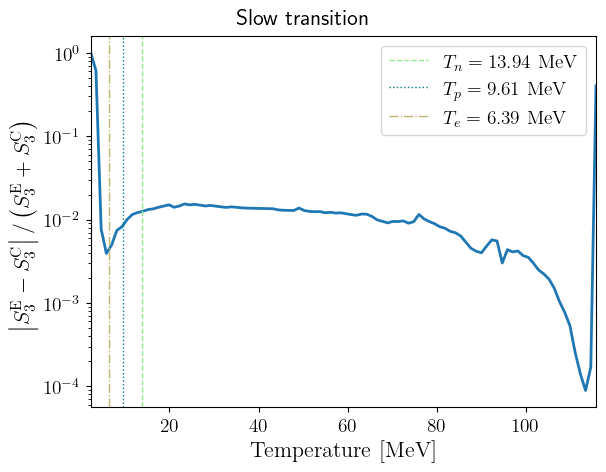

In [26]:
# Find common x values and compute relative differences
common_indices = np.isin(x, valid_x)
valid_indices = np.isin(valid_x, x)

# Get common x values and corresponding y values
common_x = x[common_indices]
elena_y = y[common_indices]
cosmo_y = valid_y[valid_indices]

# Calculate relative difference
relative_diff = np.abs((elena_y - cosmo_y) / (elena_y + cosmo_y))

# Plot relative difference vs common x values
plt.plot(common_x, relative_diff, linewidth=2)
plt.xlabel(f"$\mathrm{{Temperature\ [{units}]}}$")
#plt.ylabel('ciao')
plt.ylabel(r"$\left| S_3^\textrm{E} - S_3^\textrm{C} \right| / \left( S_3^\textrm{E} + S_3^\textrm{C} \right)$")
plt.yscale('log')
plt.xlim(np.min(common_x), np.max(common_x))

plt.axvline(T_nuc, color='lightgreen', linestyle='--', linewidth=1, label=f'$T_{{n}} = {T_nuc:.2f} \mathrm{{\ {units}}}$')
plt.axvline(T_perc, color='teal', linestyle=':', linewidth=1, label=f'$T_{{p}} = {T_perc:.2f} \mathrm{{\ {units}}}$')
plt.axvline(T_completion, color='darkkhaki', linestyle='-.', linewidth=1, label=f'$T_{{e}} = {T_completion:.2f} \mathrm{{\ {units}}}$')

plt.tight_layout()
plt.suptitle(f'{description} transition', y=1.00, fontsize=16)
plt.legend()
plt.savefig(figure_dir + f"CT_difference_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()

In [14]:
import pandas as pd
performance = pd.DataFrame(columns=['T', 'step', 'precision', 'S3/T', 'time', 'error'])

T = np.mean([T_min, T_max])

div = 3
repeat = 10
for step in range(-5*div, -div):
    for p in range(-6, 0):
        start = time.time()
        for _ in range(repeat):
            s3t = action_over_T(T, c_step_phi = 10**(step/div), precision = 10**p)
        end = time.time()
        if step == -5*div and p == -6:
            s3_reference = s3t
        if s3t is not None:
            error = abs(s3t - s3_reference) / s3_reference
            print(step, p, s3t, error, (end - start)/repeat, "s")
            performance = pd.concat([performance, pd.DataFrame([{'T': T, 'step': 10**(step/div), 'precision': 10**p, 'S3/T': s3t, 'time': (end - start)/repeat, 'error': error}])], ignore_index=True)
        else:
            print(step, p, "None")
            

performance.sort_values('step', ascending=True, inplace=True)
performance

-15 -6 419.46169323583734 0.0 0.9884127855300904 s


/var/folders/04/fp1djbdn4s5976r1jm7nkrsw0000gn/T/ipykernel_15838/1858512717.py:19: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  performance = pd.concat([performance, pd.DataFrame([{'T': T, 'step': 10**(step/div), 'precision': 10**p, 'S3/T': s3t, 'time': (end - start)/repeat, 'error': error}])], ignore_index=True)


-15 -5 419.46169323583734 0.0 0.9706497192382812 s
-15 -4 419.46169323583734 0.0 0.9700423002243042 s
-15 -3 419.46182359432686 3.107756718102623e-07 0.8502696990966797 s
-15 -2 419.46182359432686 3.107756718102623e-07 0.8469570875167847 s
-15 -1 419.46182359432686 3.107756718102623e-07 0.8537660121917725 s
-14 -6 419.4420902513178 4.673367040585463e-05 0.4388309717178345 s
-14 -5 419.4420902513178 4.673367040585463e-05 0.44002838134765626 s
-14 -4 419.4420902513178 4.673367040585463e-05 0.44424707889556886 s
-14 -3 419.44223240583887 4.639477290131877e-05 0.3834481954574585 s
-14 -2 419.44223240583887 4.639477290131877e-05 0.3795407772064209 s
-14 -1 419.44223240583887 4.639477290131877e-05 0.3802072048187256 s
-13 -6 419.41579325828934 0.0001094259101323874 0.21639039516448974 s
-13 -5 419.41579325828934 0.0001094259101323874 0.2075510025024414 s
-13 -4 419.41579325828934 0.0001094259101323874 0.2083183765411377 s
-13 -3 419.4159977202013 0.00010893847131438352 0.18247840404510499 s


,T,step,precision,S3/T,time,error
0,57.875,0.000010,0.000001,419.461693,0.988413,0.000000e+00
1,57.875,0.000010,0.000010,419.461693,0.970650,0.000000e+00
2,57.875,0.000010,0.000100,419.461693,0.970042,0.000000e+00
3,57.875,0.000010,0.001000,419.461824,0.850270,3.107757e-07
4,57.875,0.000010,0.010000,419.461824,0.846957,3.107757e-07
...,...,...,...,...,...,...
66,57.875,0.046416,0.000001,287.681888,0.010739,3.141641e-01
67,57.875,0.046416,0.000010,287.682000,0.010531,3.141638e-01
68,57.875,0.046416,0.000100,287.682000,0.014251,3.141638e-01
69,57.875,0.046416,0.001000,287.710247,0.009507,3.140965e-01


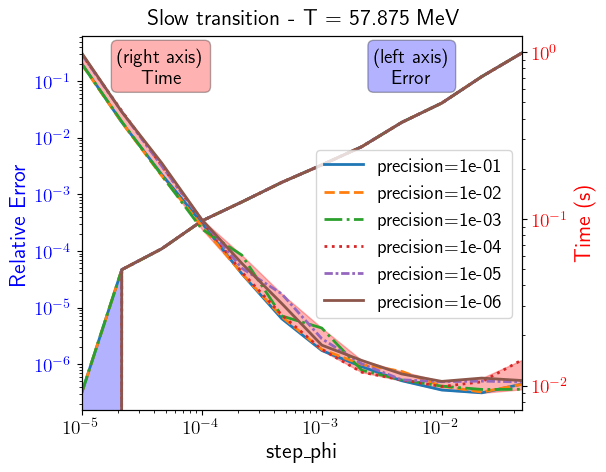

In [24]:
fig, ax1 = plt.subplots()

# Calculate error envelope for each step
steps = performance['step'].unique()
error_min = []
error_max = []
time_min = []
time_max = []

for step in steps:
    step_data = performance[performance['step'] == step]
    error_min.append(step_data['error'].min())
    error_max.append(step_data['error'].max())
    time_min.append(step_data['time'].min())
    time_max.append(step_data['time'].max())

# Plot error envelope on left axis
ax1.fill_between(steps, error_min, error_max, alpha=0.3, color='blue')

# Find precision values that form the envelope borders
border_precisions = set()

for step in steps:
    step_data = performance[performance['step'] == step]
    # Find precision values that give min and max error for this step
    min_error_idx = step_data['error'].idxmin()
    max_error_idx = step_data['error'].idxmax()
    min_time_idx = step_data['time'].idxmin()
    max_time_idx = step_data['time'].idxmax()
    
    border_precisions.add(performance.loc[min_error_idx, 'precision'])
    border_precisions.add(performance.loc[max_error_idx, 'precision'])
    border_precisions.add(performance.loc[min_time_idx, 'precision'])
    border_precisions.add(performance.loc[max_time_idx, 'precision'])

# Sort border_precisions in descending order
border_precisions_sorted = sorted(border_precisions, reverse=True)

# Define linestyles for consistency
linestyles = ['-', '--', '-.', ':', (0, (3, 1, 1, 1))]

# Add lines for border precision values
for i, precision in enumerate(border_precisions_sorted):
    precision_data = performance[performance['precision'] == precision].sort_values('step')
    ax1.plot(precision_data['step'], precision_data['error'], 
             linewidth=2, label=f'precision={precision:.0e}',
             linestyle=linestyles[i % len(linestyles)])

# Create second y-axis for time
ax2 = ax1.twinx()

# Plot time envelope on right axis
ax2.fill_between(steps, time_min, time_max, alpha=0.3, color='red')

for i, precision in enumerate(border_precisions_sorted):
    precision_data = performance[performance['precision'] == precision].sort_values('step')
    ax2.plot(precision_data['step'], precision_data['time'], 
             linewidth=2, label=f'precision={precision:.0e} time',
             linestyle=linestyles[i % len(linestyles)])

ax1.set_xscale('log')
ax1.set_yscale('log')
ax2.set_xscale('log')
ax2.set_yscale('log')
ax1.set_xlabel('step_phi')
ax1.set_ylabel('Relative Error')
ax2.set_ylabel('Time (s)')
ax1.legend(loc='center right', bbox_to_anchor=(1.0, 0.47))

# Color the y-axis labels and ticks to match the data
ax1.set_ylabel('Relative Error', color='blue')
ax2.set_ylabel('Time (s)', color='red')
ax1.tick_params(axis='y', labelcolor='blue')
ax2.tick_params(axis='y', labelcolor='red')

# Add text boxes to indicate axes
ax1.text(0.75, 0.97, '(left axis)\nError', transform=ax1.transAxes,
         verticalalignment='top', horizontalalignment='center', fontsize = 14,
         bbox=dict(boxstyle='round', facecolor='blue', alpha=0.3))
ax1.text(0.18, 0.97, '(right axis)\nTime', transform=ax1.transAxes,
         verticalalignment='top', horizontalalignment='center', fontsize = 14,
         bbox=dict(boxstyle='round', facecolor='red', alpha=0.3))

# Move left axis to right and right axis to left
# ax1.yaxis.tick_right()
# ax1.yaxis.set_label_position("right")
# ax2.yaxis.tick_left()
# ax2.yaxis.set_label_position("left")

plt.xlim(performance['step'].min(), performance['step'].max())

plt.tight_layout()
plt.suptitle(f"{description} transition - T = {performance['T'][0]} MeV", y=1.00, fontsize = 16)
plt.savefig(figure_dir + f"trade_off_{description}.pdf", dpi=300, bbox_inches='tight')
plt.show()